In [ ]:
# import libraries
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from joblib import dump
from keras import regularizers
from keras.models import Model, Sequential, load_model, model_from_json
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import preprocessing
import matplotlib
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Dense, Dropout
from keras.layers.convolutional import MaxPooling1D, Conv1D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBRegressor

In [ ]:
df = pd.read_excel('Data.xlsx')
# df.head()

In [ ]:
df1=df

In [ ]:
df.index = pd.to_datetime(df['Data'], format='%Y.%m.%d.%H.%M.%S')

In [ ]:
df = df.drop('Data',1)

In [ ]:
#df.info()

Separando os dados de treino e de teste:
========================================
Este período foi selecionado devido ser onde o compressor operou de forma constante sem falhas

In [ ]:
train = df['2018-08-02 01:00:00':'2018-09-20 00:00:00'] 
test =  df['2018-09-20 00:00:00':'2018-10-01 00:00:00']

# **Normalizar dados:**

Em seguida, uso as ferramentas de pré-processamento do Scikit-learn para dimensionar as variáveis de entrada do modelo. 
O “MinMaxScaler” simplesmente redimensiona os dados para estar no intervalo [0,1].

In [ ]:
# normalize the data
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
dump(scaler, scaler_filename)

In [ ]:
# Conversão para float32 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [ ]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train_cnn = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
print("Training data shape:", X_train_cnn.shape)
X_test_cnn = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print("Test data shape:", X_test_cnn.shape)



In [ ]:
# Preparar para teste
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(train), 
                              columns=train.columns, 
                              index=train.index)
# Utilizado Random shuffle nos dados de treinamento para selecionar de forma aleatória
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(test), 
                             columns=test.columns, 
                             index=test.index)


In [ ]:
# Hiperparâmetros do modelo

# Dimensões input
INPUT_SHAPE = (X_train.shape[1],1) 

# Tamanho do batch
BATCH_SIZE = 10

# Dropout
DROPOUT_RATE = 0.2

# Número de épocas
EPOCHS = 25

# Dados para Split
SPLIT_VAL=0.05

In [ ]:
# Arquitetura do Modelo CNN
  
model = Sequential([
        
# Primeira camada convolucional com duas operações seguidas de convolução   
Conv1D(128, kernel_size = 7, activation = 'relu', padding = 'same', input_shape = INPUT_SHAPE),
MaxPooling1D(pool_size = 2),      
Dropout(DROPOUT_RATE), 

# Segunda camada convolucional com duas operações seguidas de convolução
Conv1D(64, kernel_size = 5, activation = 'relu',padding = 'same'),
MaxPooling1D(pool_size = 2),      
Dropout(DROPOUT_RATE),

    
# Terceira camada convolucional com duas operações seguidas de convolução
Conv1D(32, kernel_size = 3, activation = 'relu',padding = 'same'),     
Conv1D(32, kernel_size = 3, activation = 'relu',padding = 'same'),     
MaxPooling1D(pool_size = 2), 
Dropout(DROPOUT_RATE), 
    

# Quinta camada convolucional com duas operações seguidas de convolução
Conv1D(64, kernel_size = 5, activation = 'relu',padding = 'same'),
MaxPooling1D(pool_size = 2), 
Dropout(DROPOUT_RATE), 

# Quinta camada convolucional com duas operações seguidas de convolução
Conv1D(128, kernel_size = 7, activation = 'relu',padding = 'same'),
Dropout(DROPOUT_RATE), 
    
Flatten(),
# Terceira camada totalmente conectada    
Dense(100,activation = 'relu'),
Dropout(DROPOUT_RATE), 
Dense(X_train.shape[1],activation = 'relu')
])
        
# Otimizador Adam

model.compile(loss='mse',optimizer='adam')



#Print Model
model.summary()

In [ ]:
# Checando a memória da GPU
!nvidia-smi

In [ ]:
# Parar recuso da memória da GPU
#pid = 3168

In [ ]:
#os.kill(pid,pid)

In [ ]:
# fit the model to the data

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=7, verbose=1, mode='auto')

history = model.fit(X_train_cnn, X_train, epochs=EPOCHS, callbacks= [monitor] , batch_size=BATCH_SIZE,
                    validation_split=SPLIT_VAL)

In [ ]:

plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.08])
plt.show()


In [ ]:
X_pred = model.predict(np.array(X_train_cnn))
X_pred = pd.DataFrame(X_pred, columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 5, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.2])

In [ ]:
X_pred = model.predict(np.array(X_test_cnn))
X_pred = pd.DataFrame(X_pred, columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.15
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

In [ ]:
X_pred_train = model.predict(np.array(X_train_cnn))
X_pred_train = pd.DataFrame(X_pred_train, columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.15
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [ ]:
scored_train.head()

In [ ]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-3,1e2], color = ['blue','red'])

In [ ]:
# Concatenado os dados de treino e teste para comparar com a função gerada pelo modelo
df_TraTes = pd.concat([train,test])

In [ ]:
# Realizando o Subset do resultado 
df0 = pd.DataFrame(scored.Loss_mae)

In [ ]:
# Agrupando o resultado dos Scores
df_fim = pd.merge(df_TraTes,df0, on=["Data"])
df_fim = df_fim.dropna()

In [ ]:
# Calculando a correlação com a perda 
df_corr = pd.DataFrame(df_fim.corr(method="pearson")["Loss_mae"])

In [ ]:
df_corr = df_corr.dropna() # Remover coluna NaN Gerada na correlação
df_corr.index.name = "Tag's" # Renomear o Index com os nomes dos Tag's

In [ ]:
# Renomear coluna 
df_corr = df_corr.rename(columns={ df_corr.columns[0]: "Correlation" })


In [ ]:
# Realizar a Filtro para verificar correlação
sel1 = df_corr.query('(Correlation > 0.3) | (Correlation < -0.4)').sort_values(by='Correlation', ascending=False)
sel1.drop('Loss_mae',axis=0)


<span style="color:red">FEATURE IMPORTANCE</span>
=============================

In [ ]:
y = df_fim.iloc[:,-1]
X = df_fim.iloc[:,0:27]

In [ ]:
# visualisations
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(30, 25)})

In [ ]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [ ]:
np.random.seed(seed = 42)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.65, random_state = 42)

In [ ]:

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

In [ ]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))

In [ ]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
base_imp

In [ ]:
plt.rcParams['figure.figsize'] = [13, 10]
var_imp_plot(base_imp, "Feature importance by - Tag's")

In [ ]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True) #False

In [ ]:
var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')

In [ ]:
# https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance

perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 100).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance Random Forest')

In [ ]:
eli5.show_weights(perm,show_feature_values=True)

In [ ]:
xgb = XGBRegressor(n_estimators=150,
                           booster='gbtree',
                           importance_type='gain',
                           gpu_id=-1,
                           verbosity=1,
                           random_state = 40)
xgb.fit(X_train, y_train)

In [ ]:
print('R^2 Training Score: {:.2f}  \nR^2 Validation Score: {:.2f}'.format(xgb.score(X_train, y_train), 
                                                                          xgb.score(X_valid, y_valid)))                        
                                                                                             

In [ ]:
base_imp_xgb = imp_df(X_train.columns, xgb.feature_importances_)
base_imp_xgb

In [ ]:
plt.rcParams['figure.figsize'] = [13, 10]
var_imp_plot(base_imp_xgb, "Feature importance by - Tag's - xgboost")

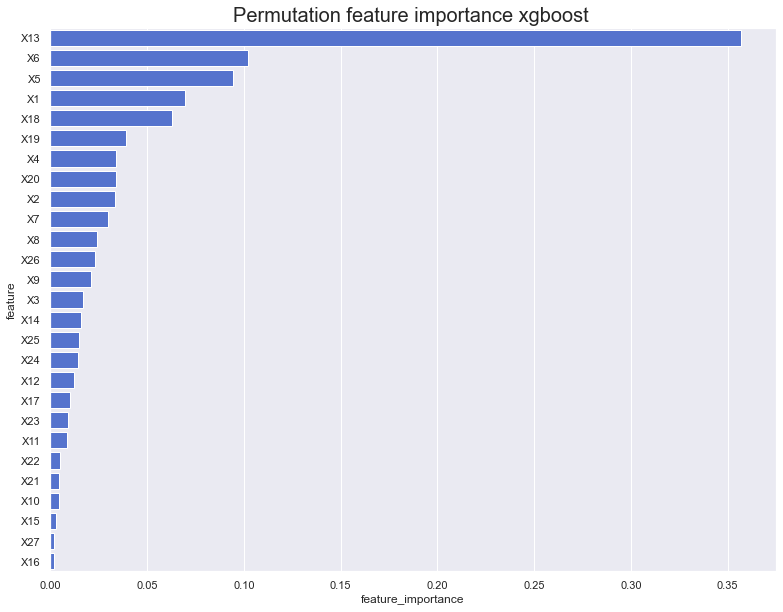

In [47]:
perm_xgb = PermutationImportance(xgb,  cv = None, refit = False, n_iter = 150).fit(X_train, y_train)
perm_imp_eli5_xgb = imp_df(X_train.columns, perm_xgb.feature_importances_)
var_imp_plot(perm_imp_eli5_xgb, 'Permutation feature importance xgboost ')

In [48]:
eli5.show_weights(perm_xgb,show_feature_values=True)


Weight,Feature
0.3571 ± 0.0223,x12
0.1019 ± 0.0126,x5
0.0943 ± 0.0085,x4
0.0698 ± 0.0067,x0
0.0630 ± 0.0046,x17
0.0389 ± 0.0039,x18
0.0338 ± 0.0070,x3
0.0337 ± 0.0032,x19
0.0334 ± 0.0067,x1
0.0300 ± 0.0031,x6


In [49]:
from sklearn.inspection import permutation_importance

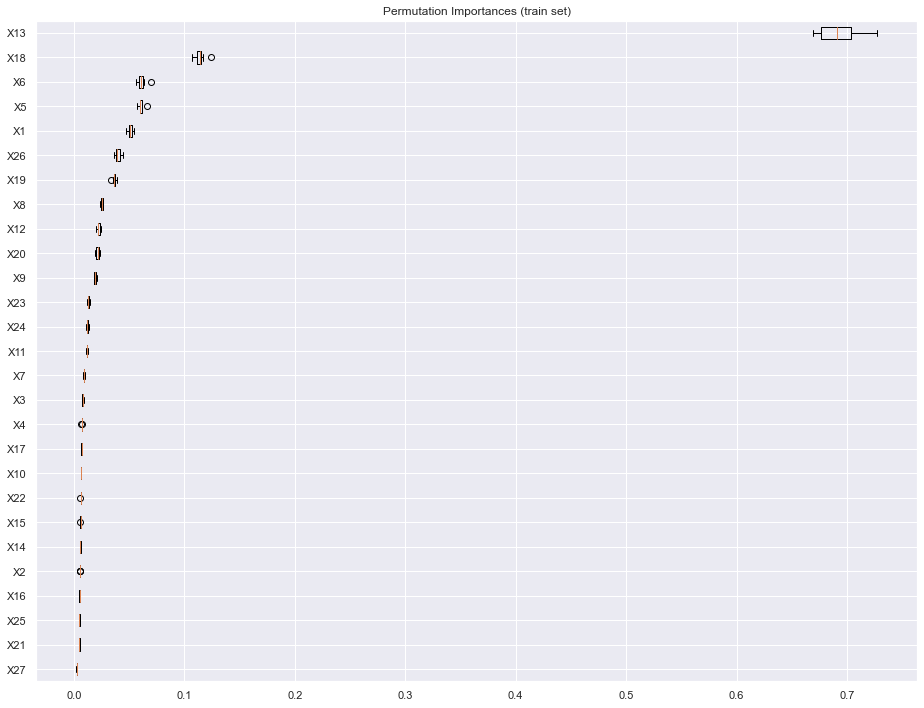

In [50]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()